In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from numpy import loadtxt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
train = pd.read_csv("data/12C_train.csv", sep="\t")
valid = pd.read_csv("data/12C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
max_features = 2000
# cut texts after this number of words
# (among top max_features most common words)
batch_size = 32

print(len(x_train), 'train sequences')
print(len(x_valid), 'test sequences')

3496 train sequences
617 test sequences


In [4]:
def end_adder(X):
    for s in range(len(X)):
        X.loc[s] += '*'
    return X

x_train = end_adder(x_train)
x_valid = end_adder(x_valid)

In [5]:
max_len = len(max(x_train, key=len))
print(max_len)

1501


In [6]:
# all amino acids (in blosum order)
aa = "ARNDCQEGHILKMFPSTWYVU*"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [7]:
set(y_train)

{'Actin binding proteins',
 'ER',
 'ER_high_curvature',
 'Endosome',
 'Ergic/cisGolgi',
 'Golgi',
 'Large Protein Complex',
 'Lysosome',
 'Mitochondrion',
 'Nuclear pore complex',
 'Peroxisome',
 'Plasma membrane'}

In [8]:
cat = ['Actin binding proteins',
 'ER',
 'ER_high_curvature',
 'Endosome',
 'Ergic/cisGolgi',
 'Golgi',
 'Large Protein Complex',
 'Lysosome',
 'Mitochondrion',
 'Nuclear pore complex',
 'Peroxisome',
 'Plasma membrane']

tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [9]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [10]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [11]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [12]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [13]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (3496, 1501)
x_valid shape: (617, 1501)


In [14]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [15]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

In [17]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_len))
model.add(Bidirectional(LSTM(128, dropout = 0.2, recurrent_dropout= 0.2)))
model.add(Dense(32))
model.add(Dense(12, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='models/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=False)

print('Train...')
model.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=25, class_weight= class_weights,            
          validation_data=[x_valid_pad, y_valid_OH],
          callbacks=[checkpointer])

Instructions for updating:
Colocations handled automatically by placer.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 3496 samples, validate on 617 samples
Epoch 1/25
3496/3496 [==============================] - 515s 147ms/step - loss: 1.7197 - accuracy: 0.4931 - val_loss: 1.7036 - val_accuracy: 0.4976

Epoch 00001: saving model to models/weights.01-1.70.hdf5
Epoch 2/25
3496/3496 [==============================] - 444s 127ms/step - loss: 1.6580 - accuracy: 0.4974 - val_loss: 1.6400 - val_accuracy: 0.4976

Epoch 00002: saving model to models/weights.02-1.64.hdf5
Epoch 3/25
3496/3496 [==============================] - 490s 140ms/step - loss: 1.6258 - accuracy: 0.4974 - val_loss: 1.6156 - val_accuracy: 0.4992

Epoch 00003: saving model to models/weights.03-1.62.hdf5
Epoch 4/25
3496/3496 [==============================] - 485s 139ms/step - loss: 1.6059 - accuracy: 0.5037 - val_loss: 1.6329 - val_accuracy: 0.5219

Epoch 00004: saving model to models/weights.04-1.63.hdf5


In [19]:
# evaluate the model
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)

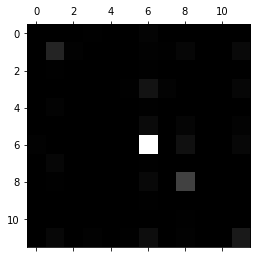

In [20]:
conf_mx = confusion_matrix(y_valid_indices, y_pred_indices)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [21]:
cat

['Actin binding proteins',
 'ER',
 'ER_high_curvature',
 'Endosome',
 'Ergic/cisGolgi',
 'Golgi',
 'Large Protein Complex',
 'Lysosome',
 'Mitochondrion',
 'Nuclear pore complex',
 'Peroxisome',
 'Plasma membrane']

In [22]:
# load model
best_model = load_model('models/weights.18-1.11.hdf5')
# summarize model.
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1501, 128)         256000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                396       
Total params: 527,788
Trainable params: 527,788
Non-trainable params: 0
_________________________________________________________________


In [23]:
y_pred = best_model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)

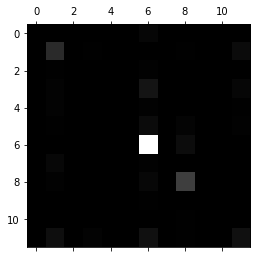

In [24]:
conf_mx = confusion_matrix(y_valid_indices, y_pred_indices)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [25]:
conf_mx

array([[  0,   1,   0,   0,   0,   0,   7,   0,   1,   0,   0,   1],
       [  0,  48,   0,   2,   0,   0,   0,   0,   2,   0,   0,  13],
       [  0,   2,   1,   0,   0,   0,   3,   0,   0,   0,   0,   0],
       [  0,   4,   0,   1,   0,   0,  23,   0,   1,   0,   0,   7],
       [  0,   4,   0,   0,   0,   0,   3,   0,   0,   0,   0,   2],
       [  0,   2,   0,   0,   0,   0,  13,   0,   5,   0,   0,   3],
       [  0,   1,   0,   0,   0,   0, 291,   0,  14,   0,   0,   1],
       [  0,   8,   0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
       [  0,   3,   0,   0,   0,   0,   9,   0,  71,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0,  16,   0,   4,   0,   0,  19,   1,   2,   0,   0,  19]])

In [26]:
model = Sequential()
model.add(Embedding(max_features, 192, input_length=max_len))
model.add(Bidirectional(LSTM(192, dropout = 0.2, recurrent_dropout= 0.2)))
model.add(Dense(12, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='models/2/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=False)

print('Train...')
model.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=50, class_weight= class_weights,            
          validation_data=[x_valid_pad, y_valid_OH],
          callbacks=[checkpointer])

Train...
Train on 3496 samples, validate on 617 samples
Epoch 1/50
3496/3496 [==============================] - 739s 211ms/step - loss: 1.7221 - accuracy: 0.4886 - val_loss: 1.6576 - val_accuracy: 0.4976

Epoch 00001: saving model to models/2/weights.01-1.66.hdf5
Epoch 2/50
3496/3496 [==============================] - 724s 207ms/step - loss: 1.6475 - accuracy: 0.4951 - val_loss: 1.6392 - val_accuracy: 0.5008

Epoch 00002: saving model to models/2/weights.02-1.64.hdf5
Epoch 3/50
3496/3496 [==============================] - 725s 207ms/step - loss: 1.6820 - accuracy: 0.4937 - val_loss: 1.7100 - val_accuracy: 0.4976

Epoch 00003: saving model to models/2/weights.03-1.71.hdf5
Epoch 4/50
3496/3496 [==============================] - 735s 210ms/step - loss: 1.6716 - accuracy: 0.4980 - val_loss: 1.6569 - val_accuracy: 0.4976

Epoch 00004: saving model to models/2/weights.04-1.66.hdf5
Epoch 5/50
3496/3496 [==============================] - 730s 209ms/step - loss: 1.6425 - accuracy: 0.4980 - val_

3496/3496 [==============================] - 728s 208ms/step - loss: 0.3845 - accuracy: 0.8796 - val_loss: 1.4231 - val_accuracy: 0.6840

Epoch 00040: saving model to models/2/weights.40-1.42.hdf5
Epoch 41/50
3496/3496 [==============================] - 723s 207ms/step - loss: 0.3693 - accuracy: 0.8830 - val_loss: 1.4354 - val_accuracy: 0.6710

Epoch 00041: saving model to models/2/weights.41-1.44.hdf5
Epoch 42/50
3496/3496 [==============================] - 721s 206ms/step - loss: 0.3199 - accuracy: 0.8962 - val_loss: 1.5442 - val_accuracy: 0.6613

Epoch 00042: saving model to models/2/weights.42-1.54.hdf5
Epoch 43/50
3496/3496 [==============================] - 722s 206ms/step - loss: 0.2961 - accuracy: 0.9082 - val_loss: 1.5586 - val_accuracy: 0.6807

Epoch 00043: saving model to models/2/weights.43-1.56.hdf5
Epoch 44/50
3496/3496 [==============================] - 721s 206ms/step - loss: 0.2752 - accuracy: 0.9191 - val_loss: 1.5449 - val_accuracy: 0.6580

Epoch 00044: saving model 

In [27]:
# load model
best_model = load_model('models/2/weights.22-1.12.hdf5')
# summarize model.
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1501, 192)         384000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 384)               591360    
_________________________________________________________________
dense_3 (Dense)              (None, 12)                4620      
Total params: 979,980
Trainable params: 979,980
Non-trainable params: 0
_________________________________________________________________


In [28]:
y_pred = best_model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)

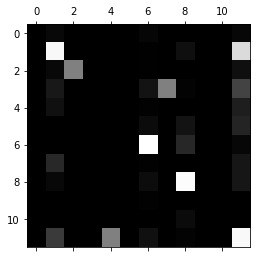

In [36]:
conf_mx = confusion_matrix(y_valid_indices, y_pred_indices)
plt.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
plt.show()

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 192, input_length=max_len))
model.add(Bidirectional(
    LSTM(192, 
         dropout = 0.2, 
         recurrent_dropout= 0.2#, 
         #kernel_regularizer=regularizers.l2(0.01),
        )))
model.add(LSTM(64, dropout = 0.2, recurrent_dropout= 0.2))
model.add(Dense(12, activation='softmax'))
